In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path as op
import itertools
import re
import xarray as xr
from sklearn.model_selection import train_test_split
import numpy.random as nr

%matplotlib inline

/scratch/adomakor412/conda/envs/MyEnv/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
nr.seed = 42

In [3]:
inputPath = '/scratch/adomakor412/all_npy3'
PATH = os.path.expanduser(inputPath)
ncPath = os.path.expanduser('/scratch/adomakor412/april_data_2019')

In [4]:
columns = [
    "time",
    "longitude",
    "latitude",
    #"band",#Necessary?
    "G17_Temp",
    "G17_mean",
    "G17_std",#mean and std outside inner for loop for comp. eff.
    "target_G16_Temp"
]

df = pd.DataFrame({},columns = columns)

In [5]:
def longitude(lonMin, lonMax, col, colSize):
    lon = (col/colSize)* (lonMax - lonMin)
    return lon

def latitude(latMin, latMax, row, rowSize):
    lat = (row/rowSize)* (latMax - latMin)
    return lat

def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [6]:
import logging
logger = logging.getLogger()

In [7]:
extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]

In [8]:
MAE = []
MSE = []
R2 = []
R2_train_test = []

dfFixedTest = []

trainSamp = [100, 1000, 10000, 100000]
for samp in trainSamp:
    with open('logML', 'a') as log:
        dataFrames = []
        for (bb,dd) in list(itertools.product([8],[5])):#Let's start with one day
            DD = str(98+dd).zfill(3)
            lookup = f'M6C08_G17_s2019{DD}0000'
            ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            npFiles = [f for f in os.listdir( PATH ) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)

            for ncf, npf in zip(ncFiles,npFiles):#can refactor to just conversion of selected files
                try:
                    imageBox = np.load(op.join( PATH,npf))
                    myFile = xr.open_dataset(op.join(ncPath,ncf))
                    planck_fk1 = float(myFile['planck_fk1'].data)
                    planck_fk2 = float(myFile['planck_fk2'].data) 
                    planck_bc1 = float(myFile['planck_bc1'].data)                       
                    planck_bc2 = float(myFile['planck_bc2'].data)

                    time = ncf[31:38]
                    G17_mean = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                    G17_std = Rad2BT(imageBox.std(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

                    hh = ncf[34:36]
                    mm = ncf[36:38]

                    #print(ncf)
                    print(str(ncf), file=log)
                    logger.info(str(ncf))

                    G16_npy = np.load( op.join(PATH, npf.replace('G16','G17',1)) )
                    G16_ncf = xr.open_dataset(op.join( ncPath, ncf.replace('G16','G17',1) ))
                    G16_fk1 = float(G16_ncf['planck_fk1'].data)
                    G16_fk2 = float(G16_ncf['planck_fk2'].data) 
                    G16_bc1 = float(G16_ncf['planck_bc1'].data)                       
                    G16_bc2 = float(G16_ncf['planck_bc2'].data)

                    target_G16_Temp = Rad2BT(G16_npy, G16_fk1, G16_fk2, G16_bc1, G16_bc2)
                    x,y = imageBox.shape[0],imageBox.shape[1]
                    #randInds = nr.randint(10000, size=(x*y))

                    #select "10,000" random points out of 401,401
                    sample = np.array([combo for combo in itertools.product(range(x),range(y))])
                    
                    inds=nr.randint(x*y, size=(samp))
                    inds.sort()
                    
                    for i,j in sample[inds]:
                        lon = longitude( extent_pc[0], extent_pc[1], i, x )
                        lat = latitude( extent_pc[2], extent_pc[3], j, y)

                        G17_Temp = Rad2BT(imageBox[i,j], planck_fk1, planck_fk2, planck_bc1, planck_bc2)#unfiltered
                        target_G16_Temp = Rad2BT( G16_npy[i,j], G16_fk1, G16_fk2, G16_bc1, G16_bc2 )

                        row = [time, lon, lat, G17_Temp, G17_mean, G17_std, target_G16_Temp]

                        dataFrames.append(pd.DataFrame([row],columns=columns))
                        #concatenate a list of single dataframes after done with loop for speed " pandas.concat"
                        #z score versus the standard deviation for single image, can normalize across all image

                except ValueError as e:
                    logger.exception(e)
                    print(e)
                    print(e, file=log)
                    continue
                 
        print('Wrapping up on sample size:', samp)
        
        df=pd.concat(dataFrames)
        df = df.dropna()
        
        from sklearn.neural_network import MLPRegressor
        #from sklearn.datasets import make_regression
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import mean_squared_error
        
        dfSample = df#df.sample(n=samp)
        X = dfSample.drop(["target_G16_Temp"],axis=1).astype('float')#try as float
        y = dfSample.drop(columns[:-1],axis=1).astype('float')
            
        from sklearn.metrics import mean_squared_error
        X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y),random_state=1,test_size=0.0)
        regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
        
        if len(dfFixedTest)==0:
            dfFixedTest = df.sample(1000)
            X_test = dfFixedTest.drop(["target_G16_Temp"],axis=1).astype('float')
            y_test = np.ravel(dfFixedTest.drop(columns[:-1],axis=1).astype('float'))

        train = regr.score(X_train,y_train)
        test = regr.score(X_test, y_test)

        R2.append(train)
        R2_train_test.append(train/test)

        prediction = regr.predict(X_train)
        errors = abs(prediction - y_train)

        MAE.append( round(np.mean(errors), 2))

        MSE.append(mean_squared_error(prediction, y_test))
        
        print('MAE', MAE)
        print('MSE', MSE)
        print('R2',R2)
        print('R2 train to test ratio',R2_train_test)
# df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=columns)
# for column in df.columns:
#     if df[column].dtype == "object":
#         df[column] = df[column].str.strip()
# df = df.dropna()

Wrapping up on sample size: 100


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
print('MAE', MAE)
print('MSE', MSE)
print('R2',R2)
print('R2 train to test ratio',R2_train_test)

In [9]:
inputPath = '/scratch/adomakor412/july_25-26_2019_npy'
PATH = os.path.expanduser(inputPath)
ncPath = os.path.expanduser('/scratch/adomakor412/july_25-26_2019')

MAE_ML = []
MSE_ML = []
R2_ML = []
R2_ML_train_test = []

MAE_pCal = []
MSE_pCal = []
R2_pCal = []
R2_pCal_train_test = []

dfFixedTest_ML = []#df.iloc[[inds]]
dfFixedTest_pCal = []#

trainSamp = [100, 1000, 10000, 100000]
for samp in trainSamp:
    dataFrames = []
    with open('logML', 'a') as log:
        DD = 0 #placeholder
        for (bb,dd,SS) in list(itertools.product([8],[206,207],[17])):
            DD = str(dd).zfill(3)
            lookup = f'M6C08_G{SS}_s2019{DD}1200'
            ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            npFiles = [f for f in os.listdir( PATH ) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            
            #randInds = nr.randint(samp, size=(x*y))
            #randInds.sort()

            for ncf, npf in zip(ncFiles,npFiles):#for ncf, npf in zip(ncFiles,npFiles)[randInds] day sample <=576
                try:
                    imageBox = np.load(op.join( PATH,npf))
                    myFile = xr.open_dataset(op.join(ncPath,ncf))
                    planck_fk1 = float(myFile['planck_fk1'].data)
                    planck_fk2 = float(myFile['planck_fk2'].data) 
                    planck_bc1 = float(myFile['planck_bc1'].data)                       
                    planck_bc2 = float(myFile['planck_bc2'].data)

                    time = ncf[31:38]
                    G17_mean = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                    G17_std = Rad2BT(imageBox.std(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

                    hh = ncf[34:36]
                    mm = ncf[36:38]

                    print(str(ncf), file=log)
                    logger.info(str(ncf))

                    G16_npy = np.load( op.join(PATH, npf.replace('G16','G17',1)) )
                    G16_ncf = xr.open_dataset(op.join( ncPath, ncf.replace('G16','G17',1) ))
                    G16_fk1 = float(G16_ncf['planck_fk1'].data)
                    G16_fk2 = float(G16_ncf['planck_fk2'].data) 
                    G16_bc1 = float(G16_ncf['planck_bc1'].data)                       
                    G16_bc2 = float(G16_ncf['planck_bc2'].data)

                    target_G16_Temp = Rad2BT(G16_npy, G16_fk1, G16_fk2, G16_bc1, G16_bc2)
                    x,y = imageBox.shape[0],imageBox.shape[1]

                    #select "10,000" random points out of 401,401
                    sample = np.array([combo for combo in itertools.product(range(x),range(y))])
                    inds=nr.randint(x*y, size=(samp))
                    inds.sort()
                    
                    for i,j in sample[inds]:#bottleneck for time
                        lon = longitude( extent_pc[0], extent_pc[1], i, x )
                        lat = latitude( extent_pc[2], extent_pc[3], j, y)

                        G17_Temp = Rad2BT(imageBox[i,j], planck_fk1, planck_fk2, planck_bc1, planck_bc2)#unfiltered
                        target_G16_Temp = Rad2BT( G16_npy[i,j], G16_fk1, G16_fk2, G16_bc1, G16_bc2 )

                        row = [time, lon, lat, G17_Temp, G17_mean, G17_std, target_G16_Temp]

                        dataFrames.append(pd.DataFrame([row],columns=columns))
                        #concatenate a list of single dataframes after done with loop for speed " pandas.concat"
                        #z score versus the standard deviation for single image, can normalize across all image
                    
                    df=pd.concat(dataFrames)
                    df = df.dropna()

                    from sklearn.neural_network import MLPRegressor
                    #from sklearn.datasets import make_regression
                    from sklearn.model_selection import train_test_split
                    from sklearn.metrics import mean_squared_error

                    dfSample = df.sample(n=samp)
                    X = dfSample.drop(["target_G16_Temp"],axis=1).astype('float')#try as float
                    y = dfSample.drop(columns[:-1],axis=1).astype('float')

                    from sklearn.metrics import mean_squared_error
                    X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y),random_state=1,test_size=0.0)
                    regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)


                    print('Working on samples of size:', samp)
                    if int(DD) == 206:#non pCal
                        print('Working on MLP sample')
                        dfFixedTest_ML = df.sample(samp)
                        X_test = dfFixedTest_ML.drop(["target_G16_Temp"],axis=1).astype('float')
                        y_test = np.ravel(dfFixedTest_ML.drop(columns[:-1],axis=1).astype('float'))

                        train = regr.score(X_train,y_train)
                        test = regr.score(X_test, y_test)

                        R2_ML.append(train)
                        R2_ML_train_test.append(train/test)

                        prediction = regr.predict(X_train)
                        errors = abs(prediction - y_train)

                        MAE = round(np.mean(errors), 2)
                        MAE_ML.append(MAE)

                        MSE = mean_squared_error(prediction, y_test)
                        MSE_ML.append(MSE)

                        print(MAE_ML,file=log) 
                        print(MSE_ML,file=log)
                        print(R2_ML,file=log)
                        print(R2_ML_train_test,file=log)

                    if int(DD) == 207:#pCal        
                        print('Working on pCal sample')
                        dfFixedTest_pCal = df.sample(samp)
                        X_test = dfFixedTest_pCal.drop(["target_G16_Temp"],axis=1).astype('float')
                        y_test = np.ravel(dfFixedTest_pCal.drop(columns[:-1],axis=1).astype('float'))

                        train = regr.score(X_train,y_train)
                        test = regr.score(X_test, y_test)

                        R2_pCal.append(train)
                        R2_pCal_train_test.append(train/test)

                        prediction = regr.predict(X_train)
                        errors = abs(prediction - y_train)

                        MAE = round(np.mean(errors), 2)
                        MAE_pCal.append(MAE)

                        MSE = mean_squared_error(prediction, y_test)
                        MSE_pCal.append(MSE)

                        print(MAE_pCal,file=log) 
                        print(MSE_pCal,file=log)
                        print(R2_pCal,file=log)
                        print(R2_pCal_train_test,file=log)
                except ValueError as e:
                    logger.exception(e)
                    print(e)
                    print(e, file=log)
                    continue

Working on samples of size: 100
Working on MLP sample
Working on samples of size: 100
Working on pCal sample
Working on samples of size: 1000
Working on MLP sample
Working on samples of size: 1000
Working on pCal sample
Working on samples of size: 10000
Working on MLP sample
Working on samples of size: 10000
Working on pCal sample
Working on samples of size: 100000
Working on MLP sample
Working on samples of size: 100000
Working on pCal sample


In [10]:
print(MAE_ML) 
print(MSE_ML)
print(R2_ML)
print(R2_ML_train_test)

[61576.82, 3.73, 13.39, 1401.98]
[3791704747.7053547, 23.947819356873357, 187.68718521120647, 1965559.6260174839]
[-140866512.25061402, -0.31430142078697565, -7.271591014539204, -83760.28968522263]
[1.0000000000000002, 1.0000000000000162, 0.999999999999999, 0.9999999999999997]


In [22]:
print(MAE_pCal) 
print(MSE_pCal)
print(R2_pCal)
print(R2_pCal_train_test)



[61729.15, 4.5, 4.67, 12.01]
[3810506987.426365, 34.09828876444382, 35.85388383902291, 177.8331733068234]
[-116985450.27613112, -0.3185483892766827, -0.327598562160921, -4.674342369309332]
[0.9032045972203664, 1.0072753199977458, 0.9948951762929416, 1.0042007674111846]


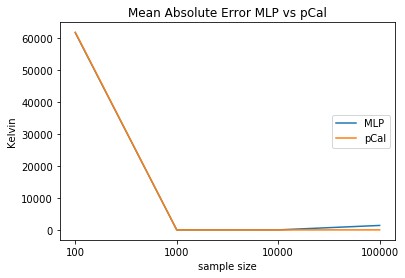

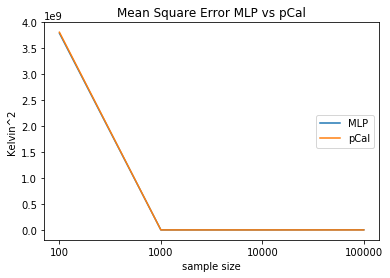

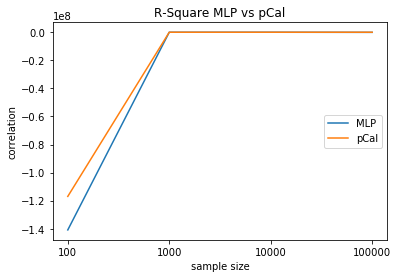

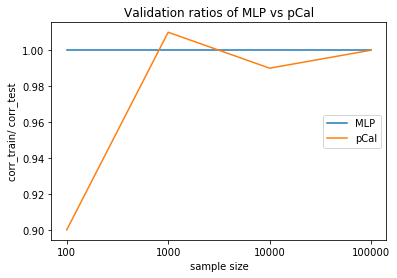

In [57]:
points =['100','1000','10000','100000']
metric_pCal = [MAE_pCal, MSE_pCal, R2_pCal, R2_pCal_train_test]
metric_ML = [MAE_ML, MSE_ML, R2_ML, R2_ML_train_test]
metric = [metric_ML, metric_pCal]
name = ['MLP','pCal']
ylabels = ['Kelvin','Kelvin^2','correlation','corr_train/ corr_test']
titles = ['Mean Absolute Error MLP vs pCal',
          'Mean Square Error MLP vs pCal',
          'R-Square MLP vs pCal',
          'Validation ratios of MLP vs pCal']

pairs = list(zip(metric_ML,metric_pCal))
for i, (ML, pCal) in enumerate(pairs):   
    for j, label in enumerate(name):
        plt.plot(points, pairs[i][j], label=label)
    plt.title(titles[i])
    plt.legend(loc="center right")
    plt.xlabel("sample size")
    plt.ylabel(ylabels[i])
    
    
    plt.show()   
#for i in range(len(points)):    

### Previous MSE was 23.96 at 1000 points sampled. Going from 1000 to 10000 points acheived better MSE (23.96 -> 0.36), MAE (3.02 Kelvins -> 0.52 Kelvins) and R^2 of both the test (-0.42 -> 0.61) and train (-0.32 ->0.6) data.

### Since the R^2 of the train and test data are similar, we know we are not overfitting.

In [53]:
metric = ['MAE','MSE','R-Square','Validation ratio']
for i,j in itertools.product(range(len(metric)), range(len(metric))):
    metric_pCal[i][j] = round(metric_pCal[i][j],2)
    metric_ML[i][j] = round(metric_ML[i][j],2)
    

In [54]:
import plotly.graph_objects as go

for i in range(len(metric)):
    fig = go.Figure(data=[go.Table(header=dict(values=[f'Metric {points[i]}pts','MLP', 'pCal']),
                     cells=dict(values=[metric, metric_ML[i], metric_pCal[i]]))
                         ])
    fig.show()